In [1]:
import glob
import os
import sys
import time

sys.path.append("/home/jigglypuff/GitHub/Kevin")
sys.path.append("")

In [2]:
from src.category.utils import get_category_index, get_category_index0
from src.color_cnn import ColorCNN

In [3]:
import fiftyone as fo
from fiftyone import ViewField as F

import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt

from val import process_batch
from utils.general import xywhn2xyxy

%matplotlib inline

# <span style="color:lightblue">Evaluate detection performance of YoloV5</span>

In the following, a trained Yolo model can be evaluated with further metrics that are not implemented in the yolov5 framework. It gives further insight in the detection performance of the model which are comparable to the metrics in QA.

In [31]:
import json

with open("/home/jigglypuff/GitHub/OSCAR_RGB_training/label_map.json") as json_file:
    label_map = json.load(json_file)

In [114]:
def evaluate_mobilenet(view,
                       model_path= "/home/jigglypuff/GitHub/OSCAR_RGB_training/ssd_mobilenet_v2_agnostic-250k-020722_tf15.pb",
                       label_map_path = "/home/jigglypuff/GitHub/Kevin/datasets/oscar-rgb-training-06_02_2022/tf/label_map.txt",
                       iouv=torch.linspace(0.05,0.95,10),
                       conf=0.25,
                       show_fp=False,
                       agnostic=True,
                       plot=True):
    
    cnn = ColorCNN(model_path, label_map_path, GPUs="0")
    category_index = get_category_index(label_map_path)
    
    
    n_obj = 0
    n_tp = torch.zeros_like(iouv)
    n_fp = torch.zeros_like(iouv)
    with fo.ProgressBar() as pb:
        for sample in pb(view):
            image = Image.open(sample.filepath)
            im = np.array(image)
            
            # from PIL import ImageDraw
            
            preds = cnn.predict(im)
            
            mask = preds["detection_scores"] > conf
            labels = preds["detection_classes"][mask]
            scores = preds["detection_scores"][mask]
            boxes = preds["detection_boxes"][mask] # ymin, xmin, ymax, xmax
            # img1 = ImageDraw.Draw(image)  
            
            boxes = boxes[:, [1,0,3,2]]
            boxes[:, 0] *= sample.metadata.width
            boxes[:, 2] *= sample.metadata.width
            boxes[:, 1] *= sample.metadata.height
            boxes[:, 3] *= sample.metadata.height
            # if len(boxes) > 0:
            #     for box in boxes:
            #         img1.rectangle(box, outline="red")
            # display(image)
            txt_2_numeric = {di["name"]:di["id"] for j, di in category_index.items()}
            
            pred = np.c_[boxes, labels]
            
            labels = [] # class, x1, y1, x2, y2 where xy1 top-left and xy2 bottom-right
            if sample.ground_truth_det:
                for det in sample.ground_truth_det.detections:
                    # convert fiftyone labels to tensors in format as required for labels
                    bb_xywhn = np.expand_dims(det.bounding_box, axis=0)
                    bb_xyxy = xywhn2xyxy(bb_xywhn, w=sample.metadata.width, h=sample.metadata.height)

                    num_class = txt_2_numeric[label_map[det.label]]
                    labels.append(torch.from_numpy(np.append(num_class, bb_xyxy)))
                    n_obj += 1 # count number of objects
                
                # compare predictions to labels
                correct = process_batch(torch.from_numpy(pred), torch.stack(labels), iouv, agnostic=agnostic)
                
                # add number of TP and FP predictions at all IOU levels
                n_tp += torch.sum(correct, axis=0)
                n_fp += torch.sum(~correct, axis=0)
                

                if show_fp and torch.sum(torch.sum(~correct, axis=0)[:3]) > 0: # [:3] bec at high IOU level there are too many FP to show each
                    preds.show()
                    
            else: # evaluating noise sequences 
                if show_fp and len(pred) > 0:
                    display(image)
                    preds.show()
                n_fp += len(pred) # add FP predictions to all IOU levels
                
    det_rate = n_tp/n_obj # detection rate, recall (how well do we find objects?)
    prec = n_tp/(n_tp+n_fp) # precision (how many predictions are correct?)
    fdr = n_fp/(n_tp+n_fp) # false discovery rate   
    f1 = 2*det_rate*prec/(det_rate + prec)
    print("\nIOU levels: ", iouv)    
    plot_and_print(det_rate, prec, fdr, f1, n_fp, n_obj, conf, plot)
            
    return det_rate, prec, fdr, f1

 100% |█████████████| 10000/10000 [6.3m elapsed, 0s remaining, 25.6 samples/s]      

IOU levels:  tensor([0.05000, 0.15000, 0.25000, 0.35000, 0.45000, 0.55000, 0.65000, 0.75000, 0.85000, 0.95000])
Results from conf:  0.25
True Positive Rate (TP/number_objects):  tensor([3.63593e-01, 2.08437e-01, 8.33614e-02, 3.43967e-02, 1.34215e-02, 5.36184e-03, 1.71984e-03, 2.36056e-04, 3.37223e-05, 0.00000e+00])
Precision:  tensor([3.19874e-01, 1.83374e-01, 7.33379e-02, 3.02608e-02, 1.18076e-02, 4.71712e-03, 1.51304e-03, 2.07672e-04, 2.96674e-05, 0.00000e+00])
False Discovery Rate:  tensor([0.68013, 0.81663, 0.92666, 0.96974, 0.98819, 0.99528, 0.99849, 0.99979, 0.99997, 1.00000])
F1-score:  tensor([3.40336e-01, 1.95104e-01, 7.80291e-02, 3.21965e-02, 1.25629e-02, 5.01886e-03, 1.60982e-03, 2.20956e-04, 3.15652e-05,         nan])


(tensor([3.63593e-01, 2.08437e-01, 8.33614e-02, 3.43967e-02, 1.34215e-02, 5.36184e-03, 1.71984e-03, 2.36056e-04, 3.37223e-05, 0.00000e+00]),
 tensor([3.19874e-01, 1.83374e-01, 7.33379e-02, 3.02608e-02, 1.18076e-02, 4.71712e-03, 1.51304e-03, 2.07672e-04, 2.96674e-05, 0.00000e+00]),
 tensor([0.68013, 0.81663, 0.92666, 0.96974, 0.98819, 0.99528, 0.99849, 0.99979, 0.99997, 1.00000]),
 tensor([3.40336e-01, 1.95104e-01, 7.80291e-02, 3.21965e-02, 1.25629e-02, 5.01886e-03, 1.60982e-03, 2.20956e-04, 3.15652e-05,         nan]))

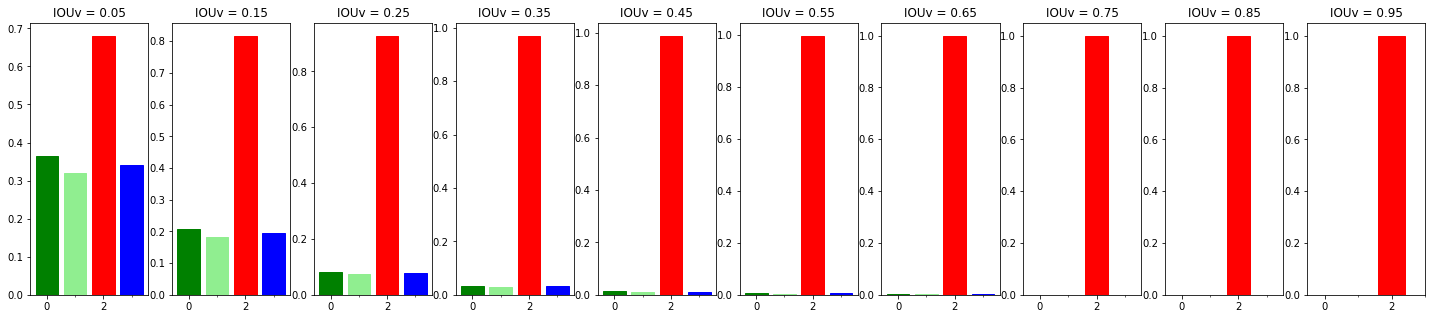

In [115]:
dataset = dset.match(F("camera_name").is_in(['Offshore_e-CAM50_CUNX_1280x960_1', 'ELP_1080_18mm_1'])).take(10000)
evaluate_mobilenet(dataset)

In [57]:
def plot_and_print(det_rate, prec, fdr, f1, n_fp, n_obj, conf=0.1, plot=True,iouv=torch.linspace(0.05, 0.95, 10)):
    labels = ["TPR", "Precision", "FDR", "F1-score"]
    if n_obj:
        print("Results from conf: ", conf)
        if plot:
            fig, axs = plt.subplots(1, len(iouv), figsize=(25, 5))
            for i in range(len(iouv)):
                barlist = axs[i].bar(range(len(labels)),[det_rate[i], prec[i], fdr[i], f1[i]])
                barlist[0].set_color("g")
                barlist[1].set_color("lightgreen")
                barlist[2].set_color("r")
                barlist[3].set_color("blue")
                axs[i].set_xticks(range(len(labels)), labels)
                axs[i].title.set_text(f"IOUv = {round(iouv[i].item(), 2)}")
            fig.show()
        print("True Positive Rate (TP/number_objects): ", det_rate)
        print("Precision: ", prec)
        print("False Discovery Rate: ", fdr)
        print("F1-score: ", f1)
    else:
        print("FP :", n_fp)

def evaluate_model(view, model_path, iouv=torch.linspace(0.05, 0.95, 10), conf=0.3, show_fp=True, show_missed=True, plot=True, agnostic=True):
    """
    evaluates the cnn on different iou-levels
    set show_fp to True to see all frames which include a wrong prediction of the models
    agnostic=True: a bounding box is counted as correct as soon as there exists a ground truth bounding box with IOU above a certain threshold, irrespective of the predicted class
    agnostic=False: a bounding box is only correct if there exists a ground truth bounding box with IOU > thresh AND the correct class is predicted
    """
    from IPython.display import display
    
    weights = model_path
    cnn = torch.hub.load('ultralytics/yolov5', 'custom', path=weights)

    cnn.conf = conf # NMS threshold
    cnn.iou = 0.05  # NMS IoU threshold
    cnn.agnostic = True 
    txt2numeric_label = {txt:n for n, txt in cnn.names.items()}
    
    n_obj = 0
    n_tp = torch.zeros_like(iouv)
    n_fp = torch.zeros_like(iouv)
    with fo.ProgressBar() as pb:
        for sample in pb(view):
            image = Image.open(sample.filepath)
            im = np.array(image)

            preds = cnn.forward(im)
            pred = preds.pandas().xyxy[0].to_numpy()[:, :-1].astype("float64") # x1, y1, x2, y2, numeric_class

            labels = [] # class, x1, y1, x2, y2 where xy1 top-left and xy2 bottom-right
            if sample.ground_truth_det:
                for det in sample.ground_truth_det.detections:
                    # convert fiftyone labels to tensors in format as required for labels
                    bb_xywhn = np.expand_dims(det.bounding_box, axis=0)
                    bb_xyxy = xywhn2xyxy(bb_xywhn, w=sample.metadata.width, h=sample.metadata.height)
                    num_class = txt2numeric_label[label_map[det.label]]
                    labels.append(torch.from_numpy(np.append(num_class, bb_xyxy)))
                    n_obj += 1 # count number of objects
                
                # compare predictions to labels
                correct = process_batch(torch.from_numpy(pred), torch.stack(labels), iouv, agnostic=agnostic)
                
                # add number of TP and FP predictions at all IOU levels
                n_tp += torch.sum(correct, axis=0)
                n_fp += torch.sum(~correct, axis=0)
                
                if show_missed:
                    pass
                if show_fp and torch.sum(torch.sum(~correct, axis=0)[:3]) > 0: # [:3] bec at high IOU level there are too many FP to show each
                    preds.show()
                    
            else: # evaluating noise sequences 
                if show_fp and len(pred) > 0:
                    display(image)
                    preds.show()
                n_fp += len(pred) # add FP predictions to all IOU levels
                
    det_rate = n_tp/n_obj # detection rate, recall (how well do we find objects?)
    prec = n_tp/(n_tp+n_fp) # precision (how many predictions are correct?)
    fdr = n_fp/(n_tp+n_fp) # false discovery rate   
    f1 = 2*det_rate*prec/(det_rate + prec)
    print("\nIOU levels: ", iouv)    
    plot_and_print(det_rate, prec, fdr, f1, n_fp, n_obj, conf, plot)
            
    return det_rate, prec, fdr, f1

In [6]:
dset = fo.load_dataset("RGB_train_2023-03-28")

Using cache found in /home/jigglypuff/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 v7.0-0-g915bbf2 Python-3.9.16 torch-1.13.1+cu117 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11019MiB)

Fusing layers... 
Model summary: 206 layers, 3102712 parameters, 0 gradients, 4.3 GFLOPs
Adding AutoShape... 


 100% |█████████████| 10000/10000 [2.8m elapsed, 0s remaining, 61.5 samples/s]       

IOU levels:  tensor([0.05000, 0.15000, 0.25000, 0.35000, 0.45000, 0.55000, 0.65000, 0.75000, 0.85000, 0.95000])
Results from conf:  0.1
True Positive Rate (TP/number_objects):  tensor([5.88863e-01, 3.76070e-01, 9.39500e-02, 1.86957e-02, 3.57071e-03, 7.41090e-04, 1.68430e-04, 0.00000e+00, 0.00000e+00, 0.00000e+00])
Precision:  tensor([8.35053e-01, 5.33295e-01, 1.33228e-01, 2.65119e-02, 5.06353e-03, 1.05092e-03, 2.38846e-04, 0.00000e+00, 0.00000e+00, 0.00000e+00])
False Discovery Rate:  tensor([0.16495, 0.46670, 0.86677, 0.97349, 0.99494, 0.99895, 0.99976, 1.00000, 1.00000, 1.00000])
F1-score:  tensor([6.90676e-01, 4.41090e-01, 1.10194e-01, 2.19281e-02, 4.18807e-03, 8.69222e-04, 1.97550e-04,         nan,         nan,         nan])


Using cache found in /home/jigglypuff/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 v7.0-0-g915bbf2 Python-3.9.16 torch-1.13.1+cu117 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11019MiB)

Fusing layers... 
Model summary: 206 layers, 3102712 parameters, 0 gradients, 4.3 GFLOPs
Adding AutoShape... 


 100% |███████████████| 2306/2306 [33.9s elapsed, 0s remaining, 68.6 samples/s]      

IOU levels:  tensor([0.05000, 0.15000, 0.25000, 0.35000, 0.45000, 0.55000, 0.65000, 0.75000, 0.85000, 0.95000])
FP : tensor([605., 605., 605., 605., 605., 605., 605., 605., 605., 605.])


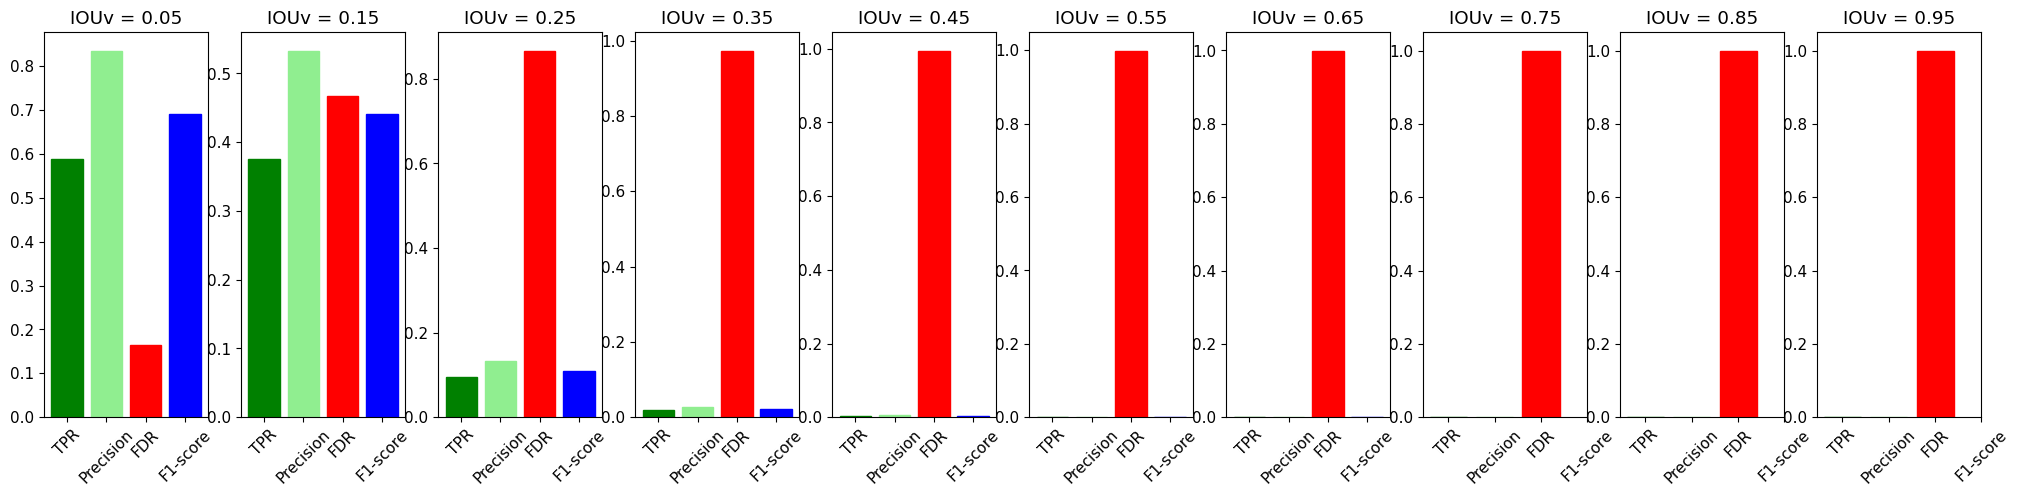

In [81]:
dataset = dset.match_tags("val")
model_path = "/home/jigglypuff/GitHub/yolov5-extended/runs/train/RGB_25k_fineTuneSnglCls_yolov5n6_trained4singleCls/weights/best.pt"
tp, fp,_,_ = evaluate_model(dataset.take(10000), model_path, conf=0.10, show_fp=False)
tp, fp, _, _ = evaluate_model(dataset.match_tags("noise").take(5000), model_path, conf=0.10, show_fp=False)

In [82]:
dataset = dset.match_tags("val_v2")
model_path = "/home/jigglypuff/GitHub/yolov5-extended/runs/train/RGB_25k_fineTuneSnglCls_modifiedTrainVal_yolov5n6_trained4singleCls2/weights/best.pt"
tp, fp, _, _ = evaluate_model(dataset.take(10000), model_path, conf=0.1, show_fp=False)
tp, fp, _, _ = evaluate_model(dataset.match_tags("noise").take(5000), model_path, conf=0.1, show_fp=False)

Using cache found in /home/jigglypuff/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 v7.0-0-g915bbf2 Python-3.9.16 torch-1.13.1+cu117 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11019MiB)

Fusing layers... 
Model summary: 206 layers, 3102712 parameters, 0 gradients, 4.3 GFLOPs
Adding AutoShape... 


 100% |█████████████| 10000/10000 [2.8m elapsed, 0s remaining, 60.9 samples/s]       

IOU levels:  tensor([0.05000, 0.15000, 0.25000, 0.35000, 0.45000, 0.55000, 0.65000, 0.75000, 0.85000, 0.95000])
Results from conf:  0.1
True Positive Rate (TP/number_objects):  tensor([5.62748e-01, 3.26377e-01, 8.61001e-02, 2.26829e-02, 4.91044e-03, 1.36711e-03, 2.79002e-04, 0.00000e+00, 0.00000e+00, 0.00000e+00])
Precision:  tensor([8.31787e-01, 4.82412e-01, 1.27263e-01, 3.35272e-02, 7.25803e-03, 2.02070e-03, 4.12388e-04, 0.00000e+00, 0.00000e+00, 0.00000e+00])
False Discovery Rate:  tensor([0.16821, 0.51759, 0.87274, 0.96647, 0.99274, 0.99798, 0.99959, 1.00000, 1.00000, 1.00000])
F1-score:  tensor([6.71315e-01, 3.89343e-01, 1.02711e-01, 2.70590e-02, 5.85778e-03, 1.63086e-03, 3.32829e-04,         nan,         nan,         nan])


Using cache found in /home/jigglypuff/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 v7.0-0-g915bbf2 Python-3.9.16 torch-1.13.1+cu117 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11019MiB)

Fusing layers... 
Model summary: 206 layers, 3102712 parameters, 0 gradients, 4.3 GFLOPs
Adding AutoShape... 


 100% |███████████████| 2063/2063 [31.4s elapsed, 0s remaining, 67.5 samples/s]      

IOU levels:  tensor([0.05000, 0.15000, 0.25000, 0.35000, 0.45000, 0.55000, 0.65000, 0.75000, 0.85000, 0.95000])
FP : tensor([395., 395., 395., 395., 395., 395., 395., 395., 395., 395.])
